In [8]:
import tensorflow as tf

print("Tensorflow version: ", tf.__version__)

print("Tensorflow is built with CUDA: ", tf.test.is_built_with_cuda())

print("All devies: ", tf.config.list_physical_devices(device_type=None))

print("GPU device: ", tf.config.list_physical_devices(device_type='GPU'))

print(tf.math.reduce_sum(tf.random.normal([1, 10])))



Tensorflow version:  2.3.0
Tensorflow is built with CUDA:  False
All devies:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]
GPU device:  []
tf.Tensor(2.07612, shape=(), dtype=float32)


In [22]:
from __future__ import print_function
import tensorflow.compat.v1 as tf
import os

tf.disable_v2_behavior()

a = tf.constant(5.0, name = "a")
b = tf.constant(10.0, name = "b")

x = tf.add(a, b, name = "add")
y = tf.div(a, b, name = "divide")

with tf.Session() as sess:
    writer = tf.summary.FileWriter("./logs", sess.graph)
    print("output: ", sess.run([a, b, x, y]))  
writer.close()    
sess.close()

output:  [5.0, 10.0, 15.0, 0.5]


In [26]:
from tensorflow.python.framework import ops
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

weights = tf.Variable(tf.random_normal([2, 3], stddev = 0.1), 
                     name = "weights")

biases = tf.Variable(tf.zeros([3]), name = "biases")
custom_variable = tf.Variable(tf.zeros([3]), name = "custom")

#初始化
variable_list_custom = [weights, custom_variable]
init_custom_op = tf.variables_initializer(var_list = variable_list_custom)

#全局变量初始化
#Method-1
init_all_op = tf.global_variables_initializer()

#Method-2
all_variables_list = ops.get_collection(ops.GraphKeys.GLOBAL_VARIABLES)
init_all_op = tf.variables_initializer(var_list = all_variables_list)


2.3.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Tensorflow.ipynb                  png
cs.py                             training
linearRegressionOneVariable.ipynb


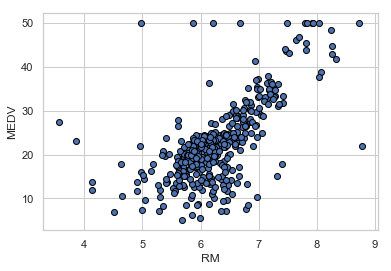

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [79]:
#线性回归

from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import os

try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

%load_ext tensorboard

!rm -rf ./logs/
!ls

dataset_path = keras.utils.get_file("housing.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data")

column_names = ['CRIM','ZN','INDUS','CHAS','NOX',
                'RM', 'AGE', 'DIS','RAD','TAX','PTRATION', 'B', 'LSTAT', 'MEDV']
raw_dataset = pd.read_csv(dataset_path, names = column_names, 
                         na_values = "?", comment = '\t',
                         sep = " ", skipinitialspace = True)

# Create a dataset instant
dataset = raw_dataset.copy()

# show last 10 data
dataset.tail(n = 10)

p = 0.8
trainDataset = dataset.sample(frac = p, random_state = 0)
testDataset = dataset.drop(trainDataset.index)

fig, ax = plt.subplots()

x = trainDataset['RM']
y = trainDataset['MEDV']
ax.scatter(x, y, edgecolors = (0, 0, 0))
ax.set_xlabel('RM')
ax.set_ylabel('MEDV')
plt.show()

trainInput = trainDataset['RM']
trainTarget = trainDataset['MEDV']
testInput = testDataset['RM']
testTarget = testDataset['MEDV']

def linear_model():
    model = keras.Sequential([
        layers.Dense(1, use_bias = True, input_shape = (1, ), name = 'layer')
    ])
    
    # Using adam optimizer
    optimizer = tf.keras.optimizers.Adam(
    learning_rate = 0.01, beta_1 = 0.9, beta_2 = 0.99, epsilon = 1e-05, amsgrad = False,
    name = 'Adam')
    
    model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mae', 'mse'])
    
    return model

# Creat model instant
model = linear_model()

# Model plot
tf.keras.utils.plot_model(
model, to_file = 'mode1.png', show_shapes = True, show_layer_names = True,
rankdir = 'TB', expand_nested = False, dpi = 100)

# Print the model summary
model.summary()




In [ ]:
# Trainning model

#params
n_epochs = 4000
batch_size = 256
n_idle_epochs = 100
n_epochs_log = 200
n_samples_save = n_epochs_log * trainInput.shape[0]
print('Checkpoint is saved for each {} samples'.format(n_samples_save))

# A mechanism that stops training if the validation loss is not improving for more than n_idle_epochs.
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = n_idle_epochs, min_delta = 0.001)

# Print the log after a certain number of epochs
predictions_list = []


class NEPOCHLogger(tf.keras.callbacks.Callback):
    def __init__(self, per_epoch = 100):
        self.seen = 0
        self.per_epoch = per_epoch
        
        
    def on_epoch_end(self, epoch, logs=None):
         if epoch % self.per_epoch == 0:
                print('Epoch {}, loss {:.2f}, val_loss {:.2f}'.format(epoch, logs['loss'], logs['val_loss']))
              
# Call the object
log_display = NEPOCHLogger(per_epoch = n_epochs_log)

# Include the epoch in the file name
checkpoint_path = "training/cp-{epoch:05d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
checkpointCallback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    verbose = 1,
    save_weights_only = True,
    save_freq = n_samples_save)

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch = 0))

# Define the Keras TensorBoard callback
logdir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir = logdir)
      
history = model.fit(
    trainInput, trainTarget, batch_size = batch_size,
    epochs = n_epochs, validation_split = 0.1, verbose = 0, 
    callbacks = [earlyStopping, log_display, tensorboard_callback, checkpointCallback])


keys: dict_keys(['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error'])


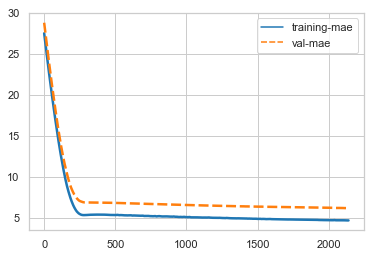

In [66]:

# The fit model returns the history object for each Keras model
print('keys:', history.history.keys())

mae = np.asarray(history.history['mean_absolute_error'])
val_mae = np.asarray(history.history['val_mean_absolute_error'])

# Creating the data frame
num_values = (len(mae))
values = np.zeros((num_values, 2), dtype = float)
values[:, 0] = mae
values[:, 1] = val_mae

# Using pandas to frame the data
steps = pd.RangeIndex(start = 0, stop = num_values)
data = pd.DataFrame(values, steps, columns = ["training-mae", "val-mae"])

sns.set(style = "whitegrid")
sns.lineplot(data = data, palette = "tab10", linewidth = 2.5)


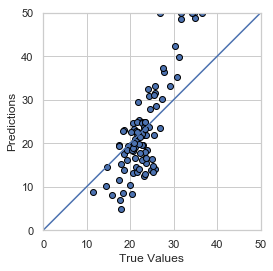

In [67]:
predictions = model.predict(testInput).flatten()
a = plt.axes(aspect = 'equal')
plt.scatter(predictions, testTarget, edgecolors = (0, 0, 0))
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
# Get the saved checkpoint files
checkpoints = []
for f_name in os.listdir(checkpoint_dir):
    if f_name.startswith('cp-'):
        file_with_no_ext = os.path.splitext(f_name)[0]
        checkpoints.append(file_with_no_ext)
    
# Return unique list elements
checkpoints = list(set(checkpoints))
print('checkpoints: ', checkpoints)
print()
# Load all model checkpoints and evaluate for each

model_improvement_progress = True
if model_improvement_progress:
    for checkpoint in checkpoints:
        count += 1
    
        
        # Call model instant
        model = linear_model()
        
        # Restore the weights
        path = os.path.join('training', checkpoint)
        model.load_weights(path)
        
        # Access to layer weights
        layer = model.get_layer('layer')
        w1, w0 = layer.get_weights()
        w1 = float(w1[0])
        w0 = float(w0[0])
        
        # Draw the scatter plot data
        fig, ax = plt.subplots()
        x = testInput
        y = testTarget
        ax.scatter(x, y, edgecolors = (0, 0, 0))
        ax.set_xlabel('RM')
        ax.set_ylabel('MEDV')
        
        # Plot the line
        y_hat = w1 * x + w0
        plt.plot(x, y_hat, '-r')
        plt.savefig('png/' + str(checkpoint) + '.png')
        print(os.path)

step: 50, loss: 0.158755, W: 0.279689, b: 0.599912
step: 100, loss: 0.157698, W: 0.276478, b: 0.622672
step: 150, loss: 0.156869, W: 0.273635, b: 0.642828
step: 200, loss: 0.156220, W: 0.271118, b: 0.660677
step: 250, loss: 0.155710, W: 0.268888, b: 0.676483
step: 300, loss: 0.155310, W: 0.266914, b: 0.690481
step: 350, loss: 0.154997, W: 0.265165, b: 0.702877
step: 400, loss: 0.154751, W: 0.263617, b: 0.713854
step: 450, loss: 0.154558, W: 0.262246, b: 0.723575
step: 500, loss: 0.154407, W: 0.261032, b: 0.732184
step: 550, loss: 0.154289, W: 0.259956, b: 0.739807
step: 600, loss: 0.154196, W: 0.259004, b: 0.746558
step: 650, loss: 0.154123, W: 0.258161, b: 0.752537
step: 700, loss: 0.154065, W: 0.257414, b: 0.757831
step: 750, loss: 0.154021, W: 0.256753, b: 0.762520
step: 800, loss: 0.153985, W: 0.256167, b: 0.766672
step: 850, loss: 0.153958, W: 0.255648, b: 0.770348
step: 900, loss: 0.153936, W: 0.255189, b: 0.773605
step: 950, loss: 0.153919, W: 0.254782, b: 0.776488
step: 1000, l

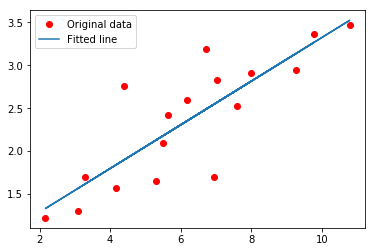

In [9]:
# Linear Regression Example.
from __future__ import absolute_import, division, print_function
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
rng = np.random

# Parameters.
learning_rate = 0.01
training_steps = 1000
display_step = 50

# Training Data.
X = np.array([3.3,4.4,5.5,6.71,6.93,4.168,9.779,6.182,7.59,2.167,
              7.042,10.791,5.313,7.997,5.654,9.27,3.1])
Y = np.array([1.7,2.76,2.09,3.19,1.694,1.573,3.366,2.596,2.53,1.221,
              2.827,3.465,1.65,2.904,2.42,2.94,1.3])

# Weight and Bias, initialized randomly.
W = tf.Variable(rng.randn(), name = "weight")
b = tf.Variable(rng.randn(), name = "bias")

# Linear regression (Wx + b).
def linear_regression(x):
    return W * x + b

# Mean square error.
def mean_square(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))

# Stochastic Gradient Descent Optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

# Optimization process.
def run_optimization():
    with tf.GradientTape() as g:
        pred = linear_regression(X)
        loss = mean_square(pred, Y)
        
    # Compute gradients
    gradients = g.gradient(loss, [W, b])
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, [W, b]))
    
# Run training.    
for step in range(1, training_steps + 1):
    run_optimization()
    
    if step % display_step == 0:
        pred = linear_regression(X)
        loss = mean_square(pred, Y)
        print("step: %i, loss: %f, W: %f, b: %f" % (step, loss, W.numpy(), b.numpy()))

# Graphic display
plt.plot(X, Y, 'ro', label = 'Original data')
plt.plot(X, np.array(W * X + b), label = 'Fitted line')
plt.legend()
plt.show()


step: 50, loss: 1.863747, accuracy: 0.753906
step: 100, loss: 1.533934, accuracy: 0.792969
step: 150, loss: 1.390031, accuracy: 0.753906
step: 200, loss: 1.137287, accuracy: 0.875000
step: 250, loss: 1.070224, accuracy: 0.843750
step: 300, loss: 0.975030, accuracy: 0.835938
step: 350, loss: 0.942612, accuracy: 0.832031
step: 400, loss: 0.919866, accuracy: 0.835938
step: 450, loss: 0.789676, accuracy: 0.863281
step: 500, loss: 0.800145, accuracy: 0.843750
step: 550, loss: 0.745467, accuracy: 0.871094
step: 600, loss: 0.692917, accuracy: 0.867188
step: 650, loss: 0.749149, accuracy: 0.835938
step: 700, loss: 0.625936, accuracy: 0.890625
step: 750, loss: 0.678670, accuracy: 0.855469
step: 800, loss: 0.666419, accuracy: 0.843750
step: 850, loss: 0.691584, accuracy: 0.812500
step: 900, loss: 0.630433, accuracy: 0.863281
step: 950, loss: 0.555410, accuracy: 0.867188
step: 1000, loss: 0.638555, accuracy: 0.843750
step: 1050, loss: 0.659104, accuracy: 0.839844
step: 1100, loss: 0.600496, accur

step: 8850, loss: 0.353767, accuracy: 0.910156
step: 8900, loss: 0.270914, accuracy: 0.921875
step: 8950, loss: 0.353607, accuracy: 0.910156
step: 9000, loss: 0.246364, accuracy: 0.933594
step: 9050, loss: 0.373921, accuracy: 0.898438
step: 9100, loss: 0.372084, accuracy: 0.898438
step: 9150, loss: 0.364441, accuracy: 0.917969
step: 9200, loss: 0.370056, accuracy: 0.906250
step: 9250, loss: 0.402422, accuracy: 0.902344
step: 9300, loss: 0.397798, accuracy: 0.894531
step: 9350, loss: 0.315375, accuracy: 0.914062
step: 9400, loss: 0.314460, accuracy: 0.917969
step: 9450, loss: 0.340772, accuracy: 0.898438
step: 9500, loss: 0.378824, accuracy: 0.878906
step: 9550, loss: 0.450537, accuracy: 0.882812
step: 9600, loss: 0.314596, accuracy: 0.925781
step: 9650, loss: 0.310298, accuracy: 0.902344
step: 9700, loss: 0.328623, accuracy: 0.906250
step: 9750, loss: 0.376915, accuracy: 0.906250
step: 9800, loss: 0.374764, accuracy: 0.894531
step: 9850, loss: 0.251593, accuracy: 0.937500
step: 9900, l

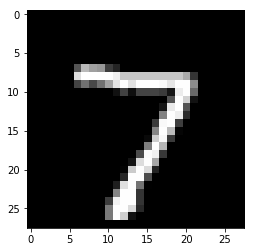

Model prediction: 7


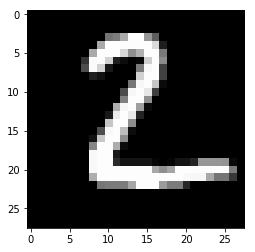

Model prediction: 2


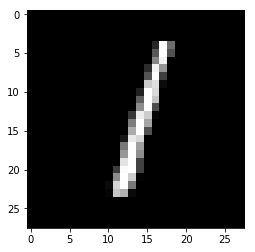

Model prediction: 1


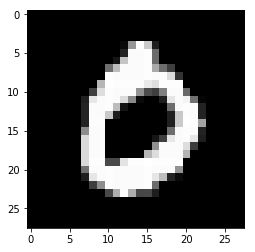

Model prediction: 0


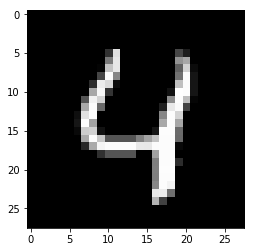

Model prediction: 4


In [17]:
# Logistic Regression Example
from __future__ import absolute_import, division, print_function
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# MNIST dataset parameters.
num_classes = 10
num_features = 784

# Training parameters.
learning_rate = 0.01
training_steps = 10000
batch_size = 256
display_step = 50

# Prepare MNIST data.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert to float32.
x_train = np.array(x_train, np.float32)
x_test = np.array(x_test, np.float32)

# Flatten images to 1-D vector of 784(28 * 28).
x_train = x_train.reshape([-1, num_features])
x_test = x_test.reshape([-1, num_features])

# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

# Use tf.data API to shuffle and batch data
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)


W = tf.Variable(tf.ones([num_features, num_classes]), name = "weight")
b = tf.Variable(tf.zeros([num_classes]), name = "bias")

# Logistic regression (Wx + b).
def logistic_regression(x):
    return tf.nn.softmax(tf.matmul(x, W) + b)

# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth = num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), -1))

# Accuracy metric.
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

# Optimization process.
def run_optimization(x, y):
    with tf.GradientTape() as g:
        pred = logistic_regression(x)
        loss = cross_entropy(pred, y)
        
    gradients = g.gradient(loss, [W, b])
    optimizer.apply_gradients(zip(gradients, [W, b]))
    
# Run training.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = logistic_regression(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))
        
# Test model on validation set.
pred = logistic_regression(x_test)
print("Test Accuracy: %f" %accuracy(pred, y_test))

# Visualize predictions.
n_images = 5
test_images = x_test[:n_images]
predictions = logistic_regression(test_images)

for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap = 'gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))